Optimal cutpoints: low = 51.72, high = 52.30 with chi2 = 22.32


c:\Users\snibb\anaconda3\envs\datasci\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\snibb\anaconda3\envs\datasci\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


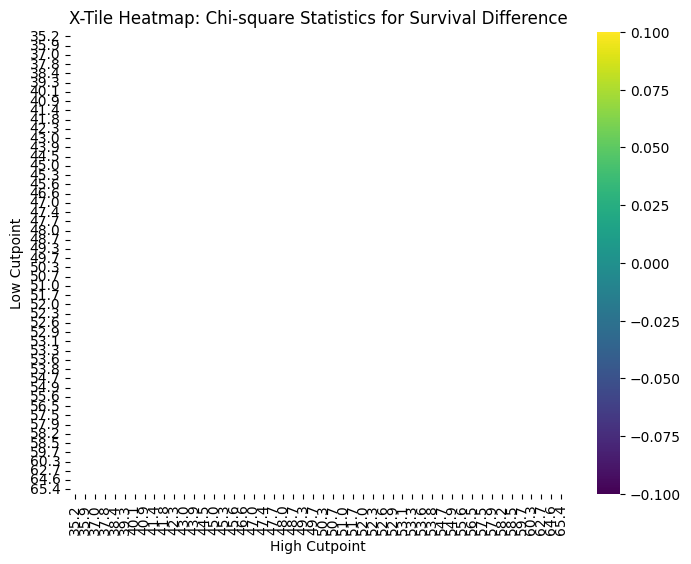

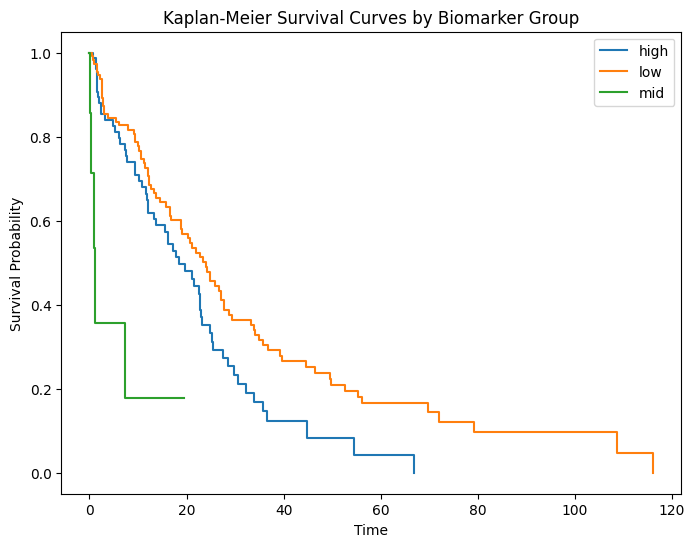

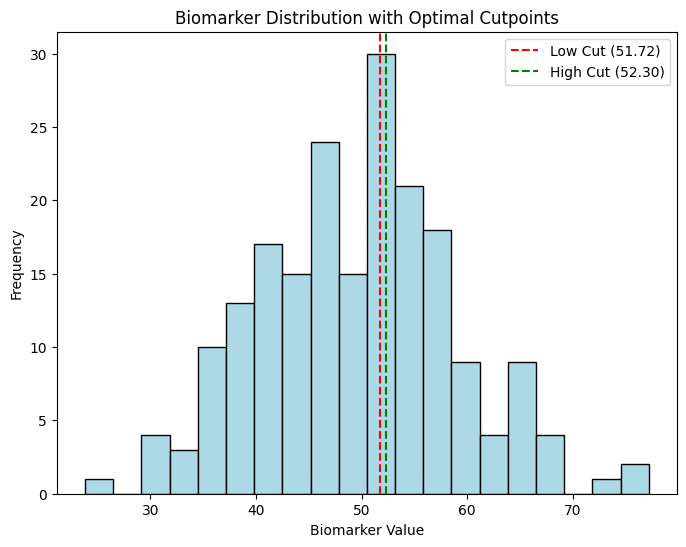

In [1]:
# %% [markdown]
# # X-Tile Method in Python: A Demonstration
#
# This notebook illustrates a simplified re-creation of the X-Tile method for optimal cutpoint selection in survival analysis.
# The method examines every possible pair of cutpoints for a continuous biomarker and computes a chi-square statistic (via the
# log-rank test) to assess the survival differences among three subpopulations (low, intermediate, high). The pair of cutpoints that
# maximizes the chi-square value is taken as the optimal division.
#
# The implementation is based on features described in Camp et al., 2004 :contentReference[oaicite:2]{index=2}&#8203;:contentReference[oaicite:3]{index=3}.

# %% [code]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
import seaborn as sns  # for a nicer heatmap plot (optional)

# %% [markdown]
# ## 1. Simulate a dataset
#
# For demonstration purposes, we simulate data for *N* patients including:
# - A continuous biomarker (e.g., expression level)
# - Survival times (generated with an exponential distribution modulated by the biomarker)
# - Censoring/event indicator

# %% [code]
np.random.seed(42)
N = 200
# Simulate a continuous biomarker (e.g., normally distributed)
biomarker = np.random.normal(loc=50, scale=10, size=N)

# Generate survival times: the hazard can be modulated by the biomarker (this is just one way to simulate data)
baseline_hazard = 0.05
# For demonstration, we modulate the scale by biomarker value (higher value could mean different risk)
survival_times = np.random.exponential(scale=1/(baseline_hazard * (biomarker/50)), size=N)

# Generate event status (1: event occurred; 0: censored) with ~70% events
events = np.random.binomial(1, 0.7, size=N)

# Build a DataFrame
df = pd.DataFrame({
    'biomarker': biomarker,
    'time': survival_times,
    'event': events
})

# Display the first rows of the dataset
df.head()
# %% [markdown]
# ## 2. (Optional) Split into training and validation sets
#
# The original X-Tile tool creates training and validation sets by alternating assignment along sorted follow-up times 
# (separately for censored and uncensored observations). For simplicity in this demo, we use the entire simulated dataset 
# as the “training” set for determining the optimal cutpoints.
#
# In a production scenario, you would split the data as described in the paper :contentReference[oaicite:4]{index=4}&#8203;:contentReference[oaicite:5]{index=5}.

# For this demo, we simply work with:
train_df = df.copy()

# %% [markdown]
# ## 3. Define functions for evaluating cutpoints
#
# The following function partitions the data into three groups (low, middle, high) using two candidate cutpoints.
# It then computes the chi-square statistic from the multivariate log-rank test to assess differences in survival.
#
# We also include a helper function to determine group assignment.

# %% [code]
def assign_groups(biomarker_values, low_cut, high_cut):
    """Assign groups based on two cutpoints.
    
    Groups: 
      - 'low' if value < low_cut
      - 'mid' if low_cut <= value < high_cut
      - 'high' if value >= high_cut
    """
    groups = pd.cut(biomarker_values, bins=[-np.inf, low_cut, high_cut, np.inf],
                    labels=['low', 'mid', 'high'])
    return groups

def compute_logrank_statistic(df, low_cut, high_cut):
    """Compute the chi-square statistic for the survival difference among three groups 
    defined by the given cutpoints."""
    groups = assign_groups(df['biomarker'], low_cut, high_cut)
    # If any group has very few samples, we return NaN to ignore such cutpoints.
    if groups.value_counts().min() < 5:
        return np.nan
    result = multivariate_logrank_test(df['time'], groups, df['event'])
    return result.test_statistic

# %% [markdown]
# ## 4. Search for the optimal cutpoints
#
# We restrict candidate cutpoints to a grid defined by the unique values of the biomarker in the training set.
# We then iterate over all pairs of candidate cutpoints (with the constraint low_cut < high_cut) and record
# the log-rank chi-square statistic. The optimal pair is the one that maximizes this statistic.
#
# **Note:** To speed up the demonstration, you might consider sub-sampling the candidate grid.

# %% [code]
# Get sorted unique biomarker values; to reduce computation, you can use percentiles
unique_vals = np.percentile(train_df['biomarker'], np.linspace(5, 95, 50))
unique_vals = np.unique(np.round(unique_vals, 2))  # round for stability

# Create a matrix to store the chi-square statistic for each candidate pair
chi2_matrix = np.full((len(unique_vals), len(unique_vals)), np.nan)

# Iterate over candidate pairs
for i, low_cut in enumerate(unique_vals):
    for j, high_cut in enumerate(unique_vals):
        if high_cut > low_cut:  # valid candidate pair
            chi2 = compute_logrank_statistic(train_df, low_cut, high_cut)
            chi2_matrix[i, j] = chi2

# Find the indices for the maximum chi-square statistic
max_idx = np.nanargmax(chi2_matrix)
low_idx, high_idx = np.unravel_index(max_idx, chi2_matrix.shape)
optimal_low = unique_vals[low_idx]
optimal_high = unique_vals[high_idx]
optimal_chi2 = chi2_matrix[low_idx, high_idx]

print(f"Optimal cutpoints: low = {optimal_low:.2f}, high = {optimal_high:.2f} with chi2 = {optimal_chi2:.2f}")
# %% [markdown]
# ## 5. Plot the X-Tile Heatmap
#
# We plot the chi-square statistics over the grid of candidate cutpoints as a heatmap.
# Only the cells with high_cut > low_cut are valid (the rest remain masked).
#
# The heatmap visually represents the “X-tile plot” from the paper :contentReference[oaicite:6]{index=6}&#8203;:contentReference[oaicite:7]{index=7}.

# %% [code]
# Mask invalid cells (where j <= i)
mask = np.triu(np.ones_like(chi2_matrix, dtype=bool))
mask = ~mask  # we want to show only where i < j

plt.figure(figsize=(8, 6))
# Using seaborn heatmap for a nicer plot
sns.heatmap(chi2_matrix, mask=~mask, xticklabels=np.round(unique_vals,1),
            yticklabels=np.round(unique_vals,1), cmap='viridis')
plt.xlabel('High Cutpoint')
plt.ylabel('Low Cutpoint')
plt.title('X-Tile Heatmap: Chi-square Statistics for Survival Difference')
plt.show()
# %% [markdown]
# ## 6. Kaplan–Meier Curves Using the Optimal Cutpoints
#
# Using the optimal cutpoints determined above, we assign the patients to three groups and plot their Kaplan–Meier survival curves.

# %% [code]
# Assign groups based on the optimal cutpoints
train_df['group'] = assign_groups(train_df['biomarker'], optimal_low, optimal_high)

# Initialize the Kaplan-Meier fitter and plot
kmf = KaplanMeierFitter()

plt.figure(figsize=(8,6))
for grp in train_df['group'].unique():
    ix = train_df['group'] == grp
    kmf.fit(train_df.loc[ix, 'time'], train_df.loc[ix, 'event'], label=str(grp))
    kmf.plot_survival_function(ci_show=False)
    
plt.title('Kaplan-Meier Survival Curves by Biomarker Group')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()

# %% [markdown]
# ## 7. (Optional) Histogram of Biomarker Distribution with Cutpoints
#
# A histogram of the biomarker with the optimal cutpoints marked can further illustrate the data division.
#
# This replicates one of the features of the X-tile tool (i.e. showing how the population is divided).

# %% [code]
plt.figure(figsize=(8, 6))
plt.hist(train_df['biomarker'], bins=20, color='lightblue', edgecolor='black')
plt.axvline(x=optimal_low, color='red', linestyle='--', label=f'Low Cut ({optimal_low:.2f})')
plt.axvline(x=optimal_high, color='green', linestyle='--', label=f'High Cut ({optimal_high:.2f})')
plt.xlabel('Biomarker Value')
plt.ylabel('Frequency')
plt.title('Biomarker Distribution with Optimal Cutpoints')
plt.legend()
plt.show()
